In [1]:
import os
import torch
import torch.distributions as tdist
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = (20,10)
torch.set_default_tensor_type('torch.cuda.FloatTensor')

from datetime import datetime
import numpy as np
from numpy import log, sqrt, exp
import imageio
from scipy.io import FortranFile
from scipy.stats import pearsonr
from scipy.interpolate import CubicSpline

In [2]:
f = FortranFile('C:/Users/Lawrence Huang/Desktop/Research/newz3taured.dat', 'r')
nlos=int(np.asscalar(f.read_ints()))
print("nlos = %d" %nlos)
npix=int(np.asscalar(f.read_ints()))
zred=np.asscalar(f.read_record('f4'))
blenkms=np.asscalar(f.read_record('f4'))
blen=np.asscalar(f.read_record('f4'))*0.001  #back into mpc/h
print(nlos,npix,zred,blenkms,blen)
taured=[]
nstep=1 #skipping through in steps of 1
for i in range(0,nlos,nstep):       
    tauredin=f.read_record('f4')
    taured.extend(tauredin)
f.close()
print('len(taured)=',len(taured))

nlos=int(nlos/nstep)

print ('nlos,npix=',nlos,npix)

taured=np.array(taured)

taured=np.reshape(taured,(nlos,1,npix))
alternativeTaured = np.reshape(taured, (256,256,1,npix))

print('shape of taured=',taured.shape)
# print(alternativeTaured[0,0] == taured[0])
# print(alternativeTaured[1,1] == taured[257])
# print(taured[0,0])

nlos = 65536
65536 512 3.0 42807.71484375 400.0
len(taured)= 33554432
nlos,npix= 65536 512
shape of taured= (65536, 1, 512)


In [3]:
tauTest = np.reshape(alternativeTaured[0:114,0:114],(114*114,1,512))
tauValidate = np.reshape(alternativeTaured[-114:,-114:],(114*114,1,512))
tauTrain = np.concatenate((
               np.reshape(alternativeTaured[:114,114:],(114*(256-114),1,512)), \
               np.reshape(alternativeTaured[114:-114],(256*(256-2*114),1,512)), \
               np.reshape(alternativeTaured[-114:,:-114],(114*(256-114),1,512))))


15.89486
signalRMS 0.6354581
fluxSignal 0.6354581


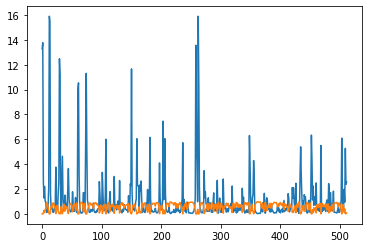

In [4]:
mintaured=taured.min()
maxtaured=taured.max()
taured[taured > 0.5e9] = -1.e10

tauTest[tauTest > 0.5e9] = -1.e10
tauValidate[tauValidate > 0.5e9] = -1.e10
tauTrain[tauTrain > 0.5e9] = -1.e10

maxtaured=taured.max()
print (maxtaured)
# set to realistic max:

taured[taured < -0.5e9] = maxtaured
tauTest[tauTest < -0.5e9] = maxtaured
tauValidate[tauValidate < -0.5e9] = maxtaured
tauTrain[tauTrain < -0.5e9] = maxtaured


flux=np.exp(-1.*taured)
fluxTest = np.exp(-1.*tauTest)
fluxValidate = np.exp(-1.*tauValidate)
fluxTrain = np.exp(-1.*tauTrain)

signalRMS = np.sqrt(np.mean(flux**2))
print("signalRMS", signalRMS)

rmsnoise=signalRMS/10 #this is the rms noise to add - if it's zero then we are try 
bignoise=signalRMS/5
hugenoise=signalRMS/2.5
# 1 is the mean of the normal distribution you are choosing from
# 2 is the standard deviation of the normal distribution
# 3 is the number of elements you get in array noise



fluxSignal = np.sqrt(np.mean(flux**2))
print("fluxSignal", fluxSignal)
taured = torch.from_numpy(taured).cuda()
tauTest = torch.from_numpy(tauTest).cuda()
tauValidate = torch.from_numpy(tauValidate).cuda()
tauTrain = torch.from_numpy(tauTrain).cuda()

flux = torch.from_numpy(flux).cuda()
fluxTest = torch.from_numpy(fluxTest).cuda()
fluxValidate = torch.from_numpy(fluxValidate).cuda()
fluxTrain = torch.from_numpy(fluxTrain).cuda()

tauredzero=taured[0,0,...]

fluxzero=flux[0,0,...]

plt.plot(tauredzero.cpu().numpy())
plt.plot(fluxzero.cpu().numpy())
plt.show()

In [10]:
noiseDict = {
    "none": 0,
    "low": 1/10,
    "mid": 1/5,
    "high": 1/2.5
}


def randomSample(num, noise="low", source="train"):
    if source == "test":
        tSet = tauTest
        fSet = fluxTest
    elif source == "validate":
        tSet = tauValidate
        fSet = fluxValidate
    elif source == "train":
        tSet = tauTrain
        fSet = fluxTrain
    
    
    
    indices = torch.randint(low=0,high=tSet.shape[0],size=(num,))
    points = torch.randint(low=0,high=512,size=(num,))
    taus = torch.zeros((num))
    fluxs = torch.zeros(num,512)
    taus = tSet[indices,0,points]
    fluxs = fSet[indices, 0]
    points = points-256
    scatterPoints = torch.zeros(num, 512, dtype=torch.long).cuda()
    scatterPoints = torch.add(scatterPoints, torch.arange(512))
    scatterPoints = torch.add(scatterPoints, points.view(num,1))
    scatterPoints[scatterPoints < 0] += 512
    scatterPoints[scatterPoints > 511] -= 512
    fluxs = fluxs.gather(1, scatterPoints)
    
    noiseGen =  torch.distributions.normal.Normal(0.0, signalRMS*noiseDict[noise], validate_args=None)
    
    fluxs = fluxs + noiseGen.sample(fluxs.shape)
    return taus, fluxs

a = tauTrain < 2
lowAddress = a.nonzero()
b = tauTrain < 30
midAddress = ((~a) == b).nonzero()
del a
c = tauTrain < 100
highAddress = ((~b) == c).nonzero()
del b
superAddress = (~c).nonzero()
del c


def normalizedRevolve(num, noise="low", source="train"):
    assert (source == "train")
    
    commonSize = num//4
    
    lowPoints = torch.randint(low=0,high=lowAddress.shape[0],size=(commonSize,))
    midPoints = torch.randint(low=0,high=midAddress.shape[0],size=(commonSize,))
    highPoints = torch.randint(low=0,high=highAddress.shape[0],size=(commonSize,))
    superPoints = torch.randint(low=0,high=superAddress.shape[0],size=(commonSize,))
    
    taus = torch.zeros((num))
    fluxs = torch.zeros(num,512)
    
    taus[:commonSize] = tauTrain[lowAddress[lowPoints][:,0],lowAddress[lowPoints][:,1],lowAddress[lowPoints][:,2]]
    fluxs[:commonSize] = fluxTrain[lowAddress[lowPoints][:,0],lowAddress[lowPoints][:,1]]
    
    taus[commonSize:2*commonSize] = tauTrain[midAddress[midPoints][:,0],midAddress[midPoints][:,1],midAddress[midPoints][:,2]]
    fluxs[commonSize:2*commonSize] = fluxTrain[midAddress[midPoints][:,0],midAddress[midPoints][:,1]]
    
    taus[2*commonSize:3*commonSize] = tauTrain[highAddress[highPoints][:,0],highAddress[highPoints][:,1],highAddress[highPoints][:,2]]
    fluxs[2*commonSize:3*commonSize] = fluxTrain[highAddress[highPoints][:,0],highAddress[highPoints][:,1]]
    
    taus[3*commonSize:4*commonSize] = tauTrain[superAddress[superPoints][:,0],superAddress[superPoints][:,1],superAddress[superPoints][:,2]]
    fluxs[3*commonSize:4*commonSize] = fluxTrain[superAddress[superPoints][:,0],superAddress[superPoints][:,1]]
    
    
    
    scatterPoints = torch.zeros(commonSize, 512, dtype=torch.long).cuda()
    scatterPoints = torch.add(scatterPoints, torch.arange(512))
    scatterPoints = torch.add(scatterPoints, lowAddress[lowPoints][:,2].view(commonSize,1)-256)
    scatterPoints[scatterPoints < 0] += 512
    scatterPoints[scatterPoints > 511] -= 512
    fluxs[:commonSize] = fluxs[:commonSize].gather(1, scatterPoints)
    
    scatterPoints = torch.zeros(commonSize, 512, dtype=torch.long).cuda()
    scatterPoints = torch.add(scatterPoints, torch.arange(512))
    scatterPoints = torch.add(scatterPoints, midAddress[midPoints][:,2].view(commonSize,1)-256)
    scatterPoints[scatterPoints < 0] += 512
    scatterPoints[scatterPoints > 511] -= 512
    fluxs[commonSize:2*commonSize] = fluxs[commonSize:2*commonSize].gather(1, scatterPoints)
    
    scatterPoints = torch.zeros(commonSize, 512, dtype=torch.long).cuda()
    scatterPoints = torch.add(scatterPoints, torch.arange(512))
    scatterPoints = torch.add(scatterPoints, highAddress[highPoints][:,2].view(commonSize,1)-256)
    scatterPoints[scatterPoints < 0] += 512
    scatterPoints[scatterPoints > 511] -= 512
    fluxs[2*commonSize:3*commonSize] = fluxs[2*commonSize:3*commonSize].gather(1, scatterPoints)
    
    scatterPoints = torch.zeros(commonSize, 512, dtype=torch.long).cuda()
    scatterPoints = torch.add(scatterPoints, torch.arange(512))
    scatterPoints = torch.add(scatterPoints, superAddress[superPoints][:,2].view(commonSize,1)-256)
    scatterPoints[scatterPoints < 0] += 512
    scatterPoints[scatterPoints > 511] -= 512
    fluxs[3*commonSize:4*commonSize] = fluxs[3*commonSize:4*commonSize].gather(1, scatterPoints)
    
    
    
    noiseGen =  torch.distributions.normal.Normal(0.0, signalRMS*noiseDict[noise], validate_args=None)
    
    fluxs = fluxs + noiseGen.sample(fluxs.shape)
    return taus, fluxs

def validate(noise="low"):
    tSet = tauValidate
    fSet = fluxValidate
    size = len(torch.flatten(tSet))
    taus = torch.zeros((size*512))
    fluxs = torch.zeros((size*512, 512))
    for i in range(size*512):
        taus[i] = tSet[i//512,0,i%512]
        fluxs[i] = spin(fSet[i//512, 0], i%512)
    fluxs += torch.from_numpy(np.random.normal(0.0,signalRMS*noiseDict[noise],fluxs.shape))
    return taus, fluxs
    
def spin(tensor, midpoint):
    return torch.cat((tensor[midpoint-256:],tensor[:midpoint-256]),dim=0)

In [26]:
def spinTest():
    a = torch.arange(512)
    for i in range(512):
        assert(spin(a,i)[256] == i)
#         print("Passed test %d/512" %(i+1))
    print("The spin function works")
    
spinTest()

The spin function works
torch.Size([50])
torch.Size([50, 512])


One Point Convolutional Network

In [ ]:
class OnePointConvNet(torch.nn.Module):
    def __init__(self):
        super(OnePointConvNet, self).__init__()
        self.hidden1 = torch.nn.Conv1d(1, 3, 5)   # hidden layer
        self.pool1 = torch.nn.MaxPool1d(5,stride = 1)
        self.hidden2 = torch.nn.Linear(504,1000)
        self.hidden3 = torch.nn.Linear(1000, 2000)
        self.hidden4 = torch.nn.Linear(2000, 2500)
        self.hidden5 = torch.nn.Linear(2500,3200)
        self.hidden6 = torch.nn.Linear(3200,4800)
        self.hidden7 = torch.nn.Conv1d(3,1,11)
        self.predict = torch.nn.Linear(4790, 1)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = self.pool1(x)
        x = F.relu(self.hidden2(x))
        x = F.relu(self.hidden3(x))
        x = F.relu(self.hidden4(x))
        x = F.relu(self.hidden5(x))
        x = F.relu(self.hidden6(x))
        x = F.relu(self.hidden7(x))
        x = self.predict(x)
        return x


Simple Regression (Formerly Linear Regression, was used to find slope)

In [ ]:
class SimpleConvNet(torch.nn.Module):
    def __init__(self):
        super(SimpleConvNet, self).__init__()
        self.hidden1 = torch.nn.Conv1d(1, 2, 5)
        self.pool1 = torch.nn.MaxPool1d(5,stride = 1)
        self.lin1 = torch.nn.Linear(504,768)
        self.lin2 = torch.nn.Linear(768,1024)
        self.hidden2 = torch.nn.Conv1d(2,1,1)
        self.predict = torch.nn.Linear(1024,512)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = self.pool1(x)
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = F.relu(self.hidden2(x))
        x = self.predict(x)             # linear output
        return x

In [ ]:
class SimpleMidpoint(torch.nn.Module):
    def __init__(self):
        super(SimpleMidpoint, self).__init__()
        self.hidden1 = torch.nn.Conv1d(1, 2, 5)
        self.pool1 = torch.nn.MaxPool1d(5,stride = 1)
        self.lin1 = torch.nn.Linear(504,64)
        self.lin2 = torch.nn.Linear(64,8)
        self.hidden2 = torch.nn.Conv1d(2,1,1)
        self.predict = torch.nn.Linear(8,1)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = self.pool1(x)
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = F.relu(self.hidden2(x))
#         x = x.view((-1,1,16))
        x = self.predict(x)             # linear output
        return x

In [ ]:
class MoreConvolution1(torch.nn.Module):
    def __init__(self):
        super(MoreConvolution1, self).__init__()
        self.conv1 = torch.nn.Conv1d(1, 4, 5)
        self.pool1 = torch.nn.MaxPool1d(5,stride = 1)
        self.lin1 = torch.nn.Linear(504,64)
        self.lin2 = torch.nn.Linear(64,8)
#         self.hidden2 = torch.nn.Conv1d(4,1,1)
        self.predict = torch.nn.Linear(32,1)   # output layer

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
#         x = F.relu(self.hidden2(x))
        x = x.view((-1,1,32))
        x = self.predict(x)             # linear output
        return x
    
class MoreConvolution2(torch.nn.Module):
    def __init__(self):
        super(MoreConvolution2, self).__init__()
        self.conv1 = torch.nn.Conv1d(1, 4, 5)
        self.pool1 = torch.nn.MaxPool1d(5,stride = 1)
        self.lin1 = torch.nn.Linear(504,64)
        self.lin2 = torch.nn.Linear(64,8)
        self.predict = torch.nn.Linear(32,1)   # output layer

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = F.relu(self.hidden2(x))
        x = self.predict(x)             # linear output
        return x

In [ ]:
class Deeper(torch.nn.Module):
    def __init__(self):
        super(Deeper, self).__init__()
        self.hidden1 = torch.nn.Conv1d(1, 4, 5)
        self.pool1 = torch.nn.MaxPool1d(5,stride = 1)
        self.lin1 = torch.nn.Linear(504,128)
        self.lin2 = torch.nn.Linear(128,32)
        self.lin3 = torch.nn.Linear(32,4)
        self.lin4 = torch.nn.Linear(4,1)
        self.predict = torch.nn.Linear(4,1)

    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = self.pool1(x)
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = F.relu(self.lin3(x))
        x = F.relu(self.lin4(x))
        x = x.view((-1,1,4))
        x = self.predict(x)             # linear output
        return x

class BigBrain(torch.nn.Module):
    def __init__(self):
        super(BigBrain, self).__init__()
        self.hidden1 = torch.nn.Conv1d(1, 4, 5)
        self.pool1 = torch.nn.MaxPool1d(5,stride = 1)
        self.lin1 = torch.nn.Linear(504,64)
        self.lin2 = torch.nn.Linear(64,120)
        self.hidden2 = torch.nn.Linear(120,30)
        self.hidden3 = torch.nn.Linear(30,5)
        self.hidden4 = torch.nn.Linear(5, 1)
        self.predict = torch.nn.Linear(4,1)
        
    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = self.pool1(x)
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = F.relu(self.hidden2(x))
#         x = x.view((-1,1,16))
        x = F.relu(self.hidden3(x))
        x = F.relu(self.hidden4(x))
        x = x.view((-1,1,4))
        x = self.predict(x)             # linear output
        return x


In [16]:
def trueLog(a):
    x = []
    y = []
    a = a.cpu()
    n = len(a)
    for i in range(n):
        if a[i] > 0:
            x.append(i)
            y.append(-log(a[i]))
            
    func = CubicSpline(x,y)
    desiredXs = np.arange(n)
    result = func(desiredXs)
    return result


tensor([0.0000, 0.6931, 1.0986, 1.0986, 1.0986])


In [ ]:
def rmse(pred, act):
    pred = torch.Tensor(pred)
    act = torch.Tensor(act)
    n = act.shape
    result = (pred-act)**2
    RMSE = (result.sum()/(act.nelement()))**0.5
    rangeRMSE = RMSE/(act.max()-act.min())
    meanRMSE = RMSE/act.mean()
    return RMSE,rangeRMSE,meanRMSE

In [ ]:
loss_func = torch.nn.MSELoss()
# npHistResult = np.histogram(taured.cpu().flatten().numpy(), bins=[0,2,30,100,1000])
# binProportions = npHistResult[0]/(2**25)
# binProportions = torch.from_numpy(binProportions).cuda()

binProportions = torch.ones((4))

def customLoss(pred, act):
    lowNum = (act < 2).sum()
    result1 = loss_func(pred[act < 2], act[act < 2])/binProportions[0]
    a = act >= 2
    b = act < 30
    midNum = (a==b).sum()
    if len((a==b).nonzero()) == 0:
        result2 = 0
    else:
        result2 = loss_func(pred[a == b], act[a == b])/binProportions[1]
    c = act < 100
    highNum = ((~b) == c).sum()
    if len(((~b) == c).nonzero()) == 0:
        result3 = 0
    else:
        result3 = loss_func(pred[(~b) == c], act[(~b) == c])/binProportions[2]
    if len((~c).nonzero()) == 0:
        result4 = 0
    else:
        result4 = loss_func(pred[~c], act[~c])/binProportions[3]
    superNum = (~c).sum()
    result = ((result1*lowNum) + (result2*midNum) + (result3*highNum) + (result4*superNum))/(lowNum+midNum+highNum+superNum)
    return result

In [1]:
netDictionary = {
#     "OnePointConvNet": OnePointConvNet,     DEPRECATED
#     "SimpleConvNet": SimpleConvNet,         DEPRECATED
    "SimpleMidpoint": SimpleMidpoint,
    "MoreConvolution1": MoreConvolution1,
    "MoreConvolution2": MoreConvolution2,
    "Deeper": Deeper,
    "BigBrain": BigBrain
    
}




class NetFactory():
    def __init__(self, netType, printAll = True):
        self.netType = netType
        self.net = netDictionary[netType]().cuda()
        self.printAll = printAll
        self.comment = ""
        
    #to test
    def onePointValidate(self):
        loss_func = torch.nn.MSELoss()
        
        loss = np.zeros(32)
        self.net.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for i in range(32):
                y = fluxTest[i,...].float()
                y = torch.reshape(y, (-1,1,512))
                prediction = self.net(y)
                loss[i] = loss_func(prediction, tauTest[i,0,256].float())
        self.net.train()
        return np.mean(loss)
    
    def graphs(self):
        nnPred = torch.zeros(12996*512)
        logPred = torch.zeros(12996*512)
        
        fluxs = torch.zeros((512,1,512))
        taus = torch.zeros((512,1,1))
        for noise in noiseDict:
            
            noiseGen =  torch.distributions.normal.Normal(0.0, signalRMS*noiseDict[noise], validate_args=None)
    #         for i in range(fluxTest.shape[0]):
    #             for midpoint in range(512):
    #                 fluxs[512*i+midpoint,0] = spin(fluxTest[i,0], midpoint) + noiseGen.sample((512,)).view((1,1,512))
    #                 taus[512*i+midpoint,0] = tauTest[i,0,midpoint]
            fluxs = fluxs.float()
            loss = torch.zeros(fluxTest.shape[0])
            self.net.eval()
            with torch.no_grad():
                for i in range(fluxTest.shape[0]):

    #             for i in range(10):
                    for midpoint in range(512):
                        fluxs[midpoint,0] = spin(fluxTest[i,0], midpoint) + noiseGen.sample((512,)).view((1,1,512))
                        taus[midpoint,0] = tauTest[i,0,midpoint]
                    prediction = self.net(fluxs)
                    nnPred[i*512:(i+1)*512] = torch.flatten(prediction)
                    logPred[i*512:(i+1)*512] = torch.from_numpy(trueLog(fluxs[i,0]))
            self.net.train()
            graphTau = torch.flatten(tauTest)
            plt.figure()
            plt.yscale("log")
            plt.xscale("log")
            plt.plot(graphTau, graphTau, "k-")
            plt.scatter(tauTest, nnPred)
            plt.title("Scatter plot of Prediction vs Tau at noise %s" %noise)
            plt.ylabel("Prediction")
            plt.xlabel("Tau")
            plt.show()

            plt.figure()
            plt.yscale("log")
            plt.xscale("log")
            plt.plot(graphTau, graphTau, "k-")
            plt.scatter(tauTest, logPred)
            plt.title("Scatter plot of Log vs Tau at noise %s" %noise)
            plt.ylabel("Log")
            plt.xlabel("Tau")
            plt.show()
        
        return nnPred, logPred
    
    
    
    
    
    
    
    
    
    
    def fullTest(self, noise):
        loss_func = torch.nn.MSELoss()
        fluxs = torch.zeros((512,1,512))
        taus = torch.zeros((512,1,1))
        noiseGen =  torch.distributions.normal.Normal(0.0, signalRMS*noiseDict[noise], validate_args=None)
#         for i in range(fluxTest.shape[0]):
#             for midpoint in range(512):
#                 fluxs[512*i+midpoint,0] = spin(fluxTest[i,0], midpoint) + noiseGen.sample((512,)).view((1,1,512))
#                 taus[512*i+midpoint,0] = tauTest[i,0,midpoint]
        fluxs = fluxs.float()
        loss = torch.zeros(fluxTest.shape[0])
        self.net.eval()
        with torch.no_grad():
            for i in range(fluxTest.shape[0]):
                for midpoint in range(512):
                    fluxs[midpoint,0] = spin(fluxTest[i,0], midpoint) + noiseGen.sample((512,)).view((1,1,512))
                    taus[midpoint,0] = tauTest[i,0,midpoint]
                prediction = self.net(fluxs)
                loss[i] = loss_func(prediction, taus)
        self.net.train()
        return loss.mean()
    
    
    def run(self, method, epochs, learningRate, noise="low"):
        now = datetime.now()
 
        print("now =", now)
    
        if method == "default":
            loss_func = torch.nn.MSELoss()
            sampler = randomSample
        elif method == "weightedLoss":
            loss_func = customLoss
            sampler = randomSample
        elif method == "normalizedSample":
            loss_func = torch.nn.MSELoss()
            sampler = normalizedRevolve
        
        
        foldrStr = self.netType + "_" + method + "_" + noise + "_" + str(epochs) + "_" + noise
        
        writer = SummaryWriter(foldrStr)
        
        writer.add_text("Net", str(self.net))
        writer.add_text("Epochs", str(epochs))
        writer.add_text("Learning Rate", str(learningRate))
        writer.add_text("Comment", self.comment)
        
        optimizer = torch.optim.Adam( self.net.parameters(), learningRate, weight_decay=0.0005 )
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 50, gamma=1)
        
        allSame = 0
        
        for epoch in range(epochs):
            
            
            tauSet,fluxSet = sampler(1000, noise)
            tauSet = tauSet.float().cuda()
            fluxSet = fluxSet.float().cuda()
            tauSet = torch.reshape(tauSet, (-1,1,1))
            fluxSet = torch.reshape(fluxSet, (-1,1,512))
            
            prediction = self.net(fluxSet)
            if torch.std(prediction) < 0.00006:
                print("std = ", torch.std(prediction))
                print("They're all", prediction[1])
                allSame += 1
                if allSame > 50:
                    return 0
            else:
                allSame == 0
                
            
            
            loss = loss_func(prediction, tauSet)     # must be (1. nn output, 2. target)
            optimizer.zero_grad()   # clear gradients for next train
            loss.backward()         # backpropagation, compute gradients
            optimizer.step()        # apply gradients
            scheduler.step()        # scheduler decreases learning rate geometrically every n epochs

            
            
            
            writer.add_scalar('Loss/train', loss, epoch)
                        
            #Start of Testing
            
#             if epoch % 1000 == 999:
#                 hundredth = plt.figure()
#                 a = torch.flatten(tauSet)
#                 b = torch.flatten(prediction)
#                 plt.title("%dth epoch predictions" %epoch)
#                 plt.plot(a.cpu().detach().numpy(),"r", label="actual")
#                 plt.plot(b.cpu().detach().numpy(),"g.", label="prediction")
#                 plt.show()
#                 writer.add_figure("Every Hundred Epochs", hundredth)
                
#                 testLoss = self.fullTest(noise)
#                 writer.add_scalar('Loss/test', testLoss, epoch)
#             for i in self.net.__dict__['_modules']:
#                 if i[0:4] != "pool":
#                     writer.add_histogram(i + '/weight', getattr(self.net, i).weight.grad, epoch)
#                     writer.add_histogram(i + '/bias', getattr(self.net, i).bias.grad, epoch)
            
            if self.printAll:
                print("Epoch = ", epoch)
                print("Training Loss = ", loss)
#                 if epoch % 1000 == 999:
#                     print("Test Loss = ", testLoss)
                    
            #End of Testing

#         a = tauSet.view((48,1))
#         b = fluxSet.view((48,512))
#         c = prediction.view((48,1))
#         testResults = plt.figure()
#         plt.plot(a.data.cpu().numpy(), "r", label="actual")
#         plt.title("prediction vs actual value")
#         plt.plot(c.data.cpu().numpy(), "g", label="prediction")
#         expPred = -np.log(b.data.cpu().numpy())
#         newExpPred = expPred[...,256]
#         plt.plot(newExpPred, 'b', label="exp")
#         plt.ylabel("Tau")
#         plt.xlabel("Sample #")
#         plt.legend()
#         plt.show()
        
        
#         writer.add_figure("Test Results", testResults)
        
#         taus, fluxs = randomSample(100)
        taus = tauValidate[0,0,...].cuda()
        fluxs = torch.zeros((512,1,512)).cuda()
        for i in range(512):
            fluxs[i] = spin(fluxValidate[0,0,...],i)
            
        noiseGen =  torch.distributions.normal.Normal(0.0, signalRMS*noiseDict[noise], validate_args=None)
    
        fluxs = fluxs + noiseGen.sample(fluxs.shape)
        
        
        taus = taus.float()
        fluxs = fluxs.float()
        taus = torch.reshape(taus, (-1,1,1))
        fluxs = torch.reshape(fluxs, (-1,1,512))
        prediction = self.net(fluxs)
        prediction = torch.flatten(prediction)
        taus = torch.flatten(taus)
        logPrediction = trueLog(torch.flatten(fluxs[256,0]))
                                       
        example = plt.figure()
        
        plt.plot(taus.data.cpu().numpy(), "r", label="actual")
        plt.plot(prediction.data.cpu().numpy(), "g", label="prediction")
        plt.plot(logPrediction, "b", label="log and cubic splines")
        plt.legend()
        plt.show()
        writer.add_figure("One Sightline", example)
        
        difference = plt.figure()
        plt.plot(prediction.data.cpu().numpy()-taus.data.cpu().numpy(), "g", label="prediction")
        plt.plot(logPrediction-taus.data.cpu().numpy(), "b", label="log and cubic splines")
        plt.legend()
        plt.title("Difference")
        plt.show()
        writer.add_figure("Difference", difference)
        
        fracDifference = plt.figure()
        plt.plot((prediction.data.cpu().numpy()-taus.data.cpu().numpy())/taus.data.cpu().numpy(), "g", label="prediction")
        plt.plot((logPrediction-taus.data.cpu().numpy())/taus.data.cpu().numpy(), "b", label="log and cubic splines")
        plt.legend()
        plt.title("Fractional Difference")
        plt.show()
        writer.add_figure("Fractional Difference", fracDifference)
        
#         taus, fluxs = validate(noise)
        taus, fluxs = sampler(10000, noise, source="validate")
        taus = taus.float().cuda()
        fluxs = fluxs.float().cuda()
        taus = torch.reshape(taus, (-1,1,1))
        fluxs = torch.reshape(fluxs, (-1,1,512))

        prediction = self.net(fluxs)
        
        a = torch.flatten(taus).detach().cpu().numpy()
        b = torch.flatten(prediction).detach().cpu().numpy()
        logP = trueLog(torch.flatten(fluxs))
        logP = logP[256::512]
        pearsonCoeff = pearsonr(a,b)
        RMSD, rangeRMSD, meanRMSD = rmse(b,a)
        
        writer.add_text("RMSD", "Total: " + str(RMSD.data.cpu().numpy()))
        
        
        print("RMSD, rangeRMSD, meanRMSD:")
        print(RMSD, rangeRMSD, meanRMSD)
        if pearsonCoeff[0] != pearsonCoeff[0]:
            return 0
        print("Pearson's Coefficient is:")
        print(pearsonCoeff)
        print("Compared to log:")
        print(pearsonr(a,logP))
        RMSD, rangeRMSD, meanRMSD = rmse(logP, a)
        writer.add_text("RMSD", "Log Total: " + str(RMSD.data.cpu().numpy()))
        print("RMSD, rangeRMSD, meanRMSD:")
        print(RMSD, rangeRMSD, meanRMSD)
        
        c = np.zeros(a.shape)
        
        newA = np.where(a>1.5, a, c)
        newB = np.where(a>1.5, b, c)
        newLogP = np.where(a>1.5, logP, c)
        newA = newA[np.nonzero(newA)]
        newB = newB[np.nonzero(newB)]
        highA = np.copy(newA)
        highB = np.copy(newB)
        newLogP = newLogP[np.nonzero(newLogP)]
        RMSD, rangeRMSD, meanRMSD = rmse(newB,newA)
        
        writer.add_text("RMSD", "High: " + str(RMSD.data.cpu().numpy()))
        print("RMSD, rangeRMSD, meanRMSD:")
        print(RMSD, rangeRMSD, meanRMSD)
        print("Pearson's Coefficient for high numbers")
        print(pearsonr(newA,newB))
        print("Compared to log:")
        print(pearsonr(newA,newLogP))
        RMSD, rangeRMSD, meanRMSD = rmse(newLogP,newA)
        
        writer.add_text("RMSD", "Log High: " + str(RMSD.data.cpu().numpy()))
        print("RMSD, rangeRMSD, meanRMSD:")
        print(RMSD, rangeRMSD, meanRMSD)
        
        
        print("percent high:")
        print(len(newA)/len(a))
        
        newA = np.where(a<1.5, a, c)
        newB = np.where(a<1.5, b, c)
        newLogP = np.where(a<1.5, logP, c)
        newA = newA[np.nonzero(newA)]
        newB = newB[np.nonzero(newB)]
        newLogP = newLogP[np.nonzero(newLogP)]
        RMSD, rangeRMSD, meanRMSD = rmse(newB,newA)
        
        writer.add_text("RMSD", "Low: " + str(RMSD.data.cpu().numpy()))
        print("RMSD, rangeRMSD, meanRMSD:")
        print(RMSD, rangeRMSD, meanRMSD)
        print("Pearson's Coefficient for low numbers")
        print(pearsonr(newA,newB))
        print("Compared to log:")
        print(pearsonr(newA,newLogP))
        RMSD, rangeRMSD, meanRMSD = rmse(newLogP,newA)
        writer.add_text("RMSD", "Log Low: " + str(RMSD.data.cpu().numpy()))
        print("RMSD, rangeRMSD, meanRMSD:")
        print(RMSD, rangeRMSD, meanRMSD)
        
        print("percent low:")
        print(len(newA)/len(a))
        
        scatterplot = plt.figure()
        plt.scatter(a,b)
        plt.title("Scatter plot of Prediction vs Tau")
        plt.ylabel("Prediction")
        plt.xlabel("Tau")
        plt.show()
        writer.add_figure("Scatterplot", scatterplot)
        
        plt.figure()
        plt.plot(highA[:100], "r", label="Tau")
        plt.plot(highB[:100], "g", label="Prediction")
        plt.title("High values of Tau vs Prediction")
        plt.legend()
        plt.show()
        
        end = datetime.now()
 
        print("end =", end)
        
        return 1
    
     
    def weightedLossRun(self, epochs, learningRate, noise="low"):
        now = datetime.now()
 
        print("now =", now)
        
        foldrStr = self.netType + "_weightedLoss" + "_" + noise + "_" + str(epochs) + "_" + noise
        
        writer = SummaryWriter(foldrStr)
        
        writer.add_text("Net", str(self.net))
        writer.add_text("Epochs", str(epochs))
        writer.add_text("Learning Rate", str(learningRate))
        writer.add_text("Comment", self.comment)
        
        optimizer = torch.optim.Adam( self.net.parameters(), learningRate, weight_decay=0.0005 )
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 50, gamma=1)
        
        allSame = 0
        
        for epoch in range(epochs):
            
            
            tauSet,fluxSet = randomSample(1000, noise)
            tauSet = tauSet.float().cuda()
            fluxSet = fluxSet.float().cuda()
            tauSet = torch.reshape(tauSet, (-1,1,1))
            fluxSet = torch.reshape(fluxSet, (-1,1,512))
            
            prediction = self.net(fluxSet)
            if torch.std(prediction) < 0.00006:
                print("std = ", torch.std(prediction))
                print("They're all", prediction[1])
                allSame += 1
                if allSame > 50:
                    return 0
            else:
                allSame == 0
                
            
            
            loss = customLoss(prediction, tauSet)     # must be (1. nn output, 2. target)
            optimizer.zero_grad()   # clear gradients for next train
            loss.backward()         # backpropagation, compute gradients
            optimizer.step()        # apply gradients
            scheduler.step()        # scheduler decreases learning rate geometrically every n epochs

            
            
            
            writer.add_scalar('Loss/train', loss, epoch)
                        
            #Start of Testing
            
#             if epoch % 1000 == 999:
#                 hundredth = plt.figure()
#                 a = torch.flatten(tauSet)
#                 b = torch.flatten(prediction)
#                 plt.title("%dth epoch predictions" %epoch)
#                 plt.plot(a.cpu().detach().numpy(),"r", label="actual")
#                 plt.plot(b.cpu().detach().numpy(),"g.", label="prediction")
#                 plt.show()
#                 writer.add_figure("Every Hundred Epochs", hundredth)
                
#                 testLoss = self.fullTest(noise)
#                 writer.add_scalar('Loss/test', testLoss, epoch)
#             for i in self.net.__dict__['_modules']:
#                 if i[0:4] != "pool":
#                     writer.add_histogram(i + '/weight', getattr(self.net, i).weight.grad, epoch)
#                     writer.add_histogram(i + '/bias', getattr(self.net, i).bias.grad, epoch)
            
            if self.printAll:
                print("Epoch = ", epoch)
                print("Training Loss = ", loss)
#                 if epoch % 1000 == 999:
#                     print("Test Loss = ", testLoss)
                    
            #End of Testing

#         a = tauSet.view((48,1))
#         b = fluxSet.view((48,512))
#         c = prediction.view((48,1))
#         testResults = plt.figure()
#         plt.plot(a.data.cpu().numpy(), "r", label="actual")
#         plt.title("prediction vs actual value")
#         plt.plot(c.data.cpu().numpy(), "g", label="prediction")
#         expPred = -np.log(b.data.cpu().numpy())
#         newExpPred = expPred[...,256]
#         plt.plot(newExpPred, 'b', label="exp")
#         plt.ylabel("Tau")
#         plt.xlabel("Sample #")
#         plt.legend()
#         plt.show()
        
        
#         writer.add_figure("Test Results", testResults)
        
#         taus, fluxs = randomSample(100)
        taus = tauValidate[0,0,...].cuda()
        fluxs = torch.zeros((512,1,512)).cuda()
        for i in range(512):
            fluxs[i] = spin(fluxValidate[0,0,...],i)
            
        noiseGen =  torch.distributions.normal.Normal(0.0, signalRMS*noiseDict[noise], validate_args=None)
    
        fluxs = fluxs + noiseGen.sample(fluxs.shape)
        
        
        taus = taus.float()
        fluxs = fluxs.float()
        taus = torch.reshape(taus, (-1,1,1))
        fluxs = torch.reshape(fluxs, (-1,1,512))
        prediction = self.net(fluxs)
        prediction = torch.flatten(prediction)
        taus = torch.flatten(taus)
        logPrediction = trueLog(torch.flatten(fluxs[256,0]))
                                       
        example = plt.figure()
        
        plt.plot(taus.data.cpu().numpy(), "r", label="actual")
        plt.plot(prediction.data.cpu().numpy(), "g", label="prediction")
        plt.plot(logPrediction, "b", label="log and cubic splines")
        plt.legend()
        plt.show()
        writer.add_figure("One Sightline", example)
        
        difference = plt.figure()
        plt.plot(prediction.data.cpu().numpy()-taus.data.cpu().numpy(), "g", label="prediction")
        plt.plot(logPrediction-taus.data.cpu().numpy(), "b", label="log and cubic splines")
        plt.legend()
        plt.title("Difference")
        plt.show()
        writer.add_figure("Difference", difference)
        
        fracDifference = plt.figure()
        plt.plot((prediction.data.cpu().numpy()-taus.data.cpu().numpy())/taus.data.cpu().numpy(), "g", label="prediction")
        plt.plot((logPrediction-taus.data.cpu().numpy())/taus.data.cpu().numpy(), "b", label="log and cubic splines")
        plt.legend()
        plt.title("Fractional Difference")
        plt.show()
        writer.add_figure("Fractional Difference", fracDifference)
        
#         taus, fluxs = validate(noise)
        taus, fluxs = randomSample(10000, noise, source="validate")
        taus = taus.float().cuda()
        fluxs = fluxs.float().cuda()
        taus = torch.reshape(taus, (-1,1,1))
        fluxs = torch.reshape(fluxs, (-1,1,512))

        prediction = self.net(fluxs)
        
        a = torch.flatten(taus).detach().cpu().numpy()
        b = torch.flatten(prediction).detach().cpu().numpy()
        logP = trueLog(torch.flatten(fluxs))
        logP = logP[256::512]
        pearsonCoeff = pearsonr(a,b)
        RMSD, rangeRMSD, meanRMSD = rmse(b,a)
        
        writer.add_text("RMSD", "Total: " + str(RMSD.data.cpu().numpy()))
        
        
        print("RMSD, rangeRMSD, meanRMSD:")
        print(RMSD, rangeRMSD, meanRMSD)
        if pearsonCoeff[0] != pearsonCoeff[0]:
            return 0
        print("Pearson's Coefficient is:")
        print(pearsonCoeff)
        print("Compared to log:")
        print(pearsonr(a,logP))
        RMSD, rangeRMSD, meanRMSD = rmse(logP, a)
        writer.add_text("RMSD", "Log Total: " + str(RMSD.data.cpu().numpy()))
        print("RMSD, rangeRMSD, meanRMSD:")
        print(RMSD, rangeRMSD, meanRMSD)
        
        c = np.zeros(a.shape)
        
        newA = np.where(a>1.5, a, c)
        newB = np.where(a>1.5, b, c)
        newLogP = np.where(a>1.5, logP, c)
        newA = newA[np.nonzero(newA)]
        newB = newB[np.nonzero(newB)]
        highA = np.copy(newA)
        highB = np.copy(newB)
        newLogP = newLogP[np.nonzero(newLogP)]
        RMSD, rangeRMSD, meanRMSD = rmse(newB,newA)
        
        writer.add_text("RMSD", "High: " + str(RMSD.data.cpu().numpy()))
        print("RMSD, rangeRMSD, meanRMSD:")
        print(RMSD, rangeRMSD, meanRMSD)
        print("Pearson's Coefficient for high numbers")
        print(pearsonr(newA,newB))
        print("Compared to log:")
        print(pearsonr(newA,newLogP))
        RMSD, rangeRMSD, meanRMSD = rmse(newLogP,newA)
        
        writer.add_text("RMSD", "Log High: " + str(RMSD.data.cpu().numpy()))
        print("RMSD, rangeRMSD, meanRMSD:")
        print(RMSD, rangeRMSD, meanRMSD)
        
        
        print("percent high:")
        print(len(newA)/len(a))
        
        newA = np.where(a<1.5, a, c)
        newB = np.where(a<1.5, b, c)
        newLogP = np.where(a<1.5, logP, c)
        newA = newA[np.nonzero(newA)]
        newB = newB[np.nonzero(newB)]
        newLogP = newLogP[np.nonzero(newLogP)]
        RMSD, rangeRMSD, meanRMSD = rmse(newB,newA)
        
        writer.add_text("RMSD", "Low: " + str(RMSD.data.cpu().numpy()))
        print("RMSD, rangeRMSD, meanRMSD:")
        print(RMSD, rangeRMSD, meanRMSD)
        print("Pearson's Coefficient for low numbers")
        print(pearsonr(newA,newB))
        print("Compared to log:")
        print(pearsonr(newA,newLogP))
        RMSD, rangeRMSD, meanRMSD = rmse(newLogP,newA)
        writer.add_text("RMSD", "Log Low: " + str(RMSD.data.cpu().numpy()))
        print("RMSD, rangeRMSD, meanRMSD:")
        print(RMSD, rangeRMSD, meanRMSD)
        
        print("percent low:")
        print(len(newA)/len(a))
        
        scatterplot = plt.figure()
        plt.scatter(a,b)
        plt.title("Scatter plot of Prediction vs Tau")
        plt.ylabel("Prediction")
        plt.xlabel("Tau")
        plt.show()
        writer.add_figure("Scatterplot", scatterplot)
        
        plt.figure()
        plt.plot(highA[:100], "r", label="Tau")
        plt.plot(highB[:100], "g", label="Prediction")
        plt.title("High values of Tau vs Prediction")
        plt.legend()
        plt.show()
        
        end = datetime.now()
 
        print("end =", end)
        
        return 1
    
    def normalizedSampleRun(self, epochs, learningRate, noise="low"):
        now = datetime.now()
 
        print("now =", now)
        
        loss_func = torch.nn.MSELoss()
        
        foldrStr = self.netType + "_normSample" + "_" + noise + "_" + str(epochs) + "_" + noise
        
        writer = SummaryWriter(foldrStr)
        
        writer.add_text("Net", str(self.net))
        writer.add_text("Epochs", str(epochs))
        writer.add_text("Learning Rate", str(learningRate))
        writer.add_text("Comment", self.comment)
        
        optimizer = torch.optim.Adam( self.net.parameters(), learningRate, weight_decay=0.0005 )
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 50, gamma=1)
        
        allSame = 0
        
        for epoch in range(epochs):
            
            
            tauSet,fluxSet = normalizedRevolve(1000, noise)
            tauSet = tauSet.float().cuda()
            fluxSet = fluxSet.float().cuda()
            tauSet = torch.reshape(tauSet, (-1,1,1))
            fluxSet = torch.reshape(fluxSet, (-1,1,512))
            
            prediction = self.net(fluxSet)
            if torch.std(prediction) < 0.00006:
                print("std = ", torch.std(prediction))
                print("They're all", prediction[1])
                allSame += 1
                if allSame > 50:
                    return 0
            else:
                allSame == 0
                
            
            
            loss = loss_func(prediction, tauSet)     # must be (1. nn output, 2. target)
            optimizer.zero_grad()   # clear gradients for next train
            loss.backward()         # backpropagation, compute gradients
            optimizer.step()        # apply gradients
            scheduler.step()        # scheduler decreases learning rate geometrically every n epochs

            
            
            
            writer.add_scalar('Loss/train', loss, epoch)
                        
            #Start of Testing
            
#             if epoch % 1000 == 999:
#                 hundredth = plt.figure()
#                 a = torch.flatten(tauSet)
#                 b = torch.flatten(prediction)
#                 plt.title("%dth epoch predictions" %epoch)
#                 plt.plot(a.cpu().detach().numpy(),"r", label="actual")
#                 plt.plot(b.cpu().detach().numpy(),"g.", label="prediction")
#                 plt.show()
#                 writer.add_figure("Every Hundred Epochs", hundredth)
                
#                 testLoss = self.fullTest(noise)
#                 writer.add_scalar('Loss/test', testLoss, epoch)
#             for i in self.net.__dict__['_modules']:
#                 if i[0:4] != "pool":
#                     writer.add_histogram(i + '/weight', getattr(self.net, i).weight.grad, epoch)
#                     writer.add_histogram(i + '/bias', getattr(self.net, i).bias.grad, epoch)
            
            if self.printAll:
                print("Epoch = ", epoch)
                print("Training Loss = ", loss)
#                 if epoch % 1000 == 999:
#                     print("Test Loss = ", testLoss)
                    
            #End of Testing

#         a = tauSet.view((48,1))
#         b = fluxSet.view((48,512))
#         c = prediction.view((48,1))
#         testResults = plt.figure()
#         plt.plot(a.data.cpu().numpy(), "r", label="actual")
#         plt.title("prediction vs actual value")
#         plt.plot(c.data.cpu().numpy(), "g", label="prediction")
#         expPred = -np.log(b.data.cpu().numpy())
#         newExpPred = expPred[...,256]
#         plt.plot(newExpPred, 'b', label="exp")
#         plt.ylabel("Tau")
#         plt.xlabel("Sample #")
#         plt.legend()
#         plt.show()
        
        
#         writer.add_figure("Test Results", testResults)
        
#         taus, fluxs = randomSample(100)
        taus = tauValidate[0,0,...].cuda()
        fluxs = torch.zeros((512,1,512)).cuda()
        for i in range(512):
            fluxs[i] = spin(fluxValidate[0,0,...],i)
            
        noiseGen =  torch.distributions.normal.Normal(0.0, signalRMS*noiseDict[noise], validate_args=None)
    
        fluxs = fluxs + noiseGen.sample(fluxs.shape)
        
        
        taus = taus.float()
        fluxs = fluxs.float()
        taus = torch.reshape(taus, (-1,1,1))
        fluxs = torch.reshape(fluxs, (-1,1,512))
        prediction = self.net(fluxs)
        prediction = torch.flatten(prediction)
        taus = torch.flatten(taus)
        logPrediction = trueLog(torch.flatten(fluxs[256,0]))
                                       
        example = plt.figure()
        
        plt.plot(taus.data.cpu().numpy(), "r", label="actual")
        plt.plot(prediction.data.cpu().numpy(), "g", label="prediction")
        plt.plot(logPrediction, "b", label="log and cubic splines")
        plt.legend()
        plt.show()
        writer.add_figure("One Sightline", example)
        
        difference = plt.figure()
        plt.plot(prediction.data.cpu().numpy()-taus.data.cpu().numpy(), "g", label="prediction")
        plt.plot(logPrediction-taus.data.cpu().numpy(), "b", label="log and cubic splines")
        plt.legend()
        plt.title("Difference")
        plt.show()
        writer.add_figure("Difference", difference)
        
        fracDifference = plt.figure()
        plt.plot((prediction.data.cpu().numpy()-taus.data.cpu().numpy())/taus.data.cpu().numpy(), "g", label="prediction")
        plt.plot((logPrediction-taus.data.cpu().numpy())/taus.data.cpu().numpy(), "b", label="log and cubic splines")
        plt.legend()
        plt.title("Fractional Difference")
        plt.show()
        writer.add_figure("Fractional Difference", fracDifference)
        
#         taus, fluxs = validate(noise)
        taus, fluxs = randomSample(10000, noise, source="validate")
        taus = taus.float().cuda()
        fluxs = fluxs.float().cuda()
        taus = torch.reshape(taus, (-1,1,1))
        fluxs = torch.reshape(fluxs, (-1,1,512))

        prediction = self.net(fluxs)
        
        a = torch.flatten(taus).detach().cpu().numpy()
        b = torch.flatten(prediction).detach().cpu().numpy()
        logP = trueLog(torch.flatten(fluxs))
        logP = logP[256::512]
        pearsonCoeff = pearsonr(a,b)
        RMSD, rangeRMSD, meanRMSD = rmse(b,a)
        print("RMSD, rangeRMSD, meanRMSD:")
        print(RMSD, rangeRMSD, meanRMSD)
        if pearsonCoeff[0] != pearsonCoeff[0]:
            return 0
        print("Pearson's Coefficient is:")
        print(pearsonCoeff)
        print("Compared to log:")
        print(pearsonr(a,logP))
        RMSD, rangeRMSD, meanRMSD = rmse(logP, a)
        print("RMSD, rangeRMSD, meanRMSD:")
        print(RMSD, rangeRMSD, meanRMSD)
        
        c = np.zeros(a.shape)
        
        newA = np.where(a>1.5, a, c)
        newB = np.where(a>1.5, b, c)
        newLogP = np.where(a>1.5, logP, c)
        newA = newA[np.nonzero(newA)]
        newB = newB[np.nonzero(newB)]
        highA = np.copy(newA)
        highB = np.copy(newB)
        newLogP = newLogP[np.nonzero(newLogP)]
        RMSD, rangeRMSD, meanRMSD = rmse(newB,newA)
        print("RMSD, rangeRMSD, meanRMSD:")
        print(RMSD, rangeRMSD, meanRMSD)
        print("Pearson's Coefficient for high numbers")
        print(pearsonr(newA,newB))
        print("Compared to log:")
        print(pearsonr(newA,newLogP))
        RMSD, rangeRMSD, meanRMSD = rmse(newLogP,newA)
        print("RMSD, rangeRMSD, meanRMSD:")
        print(RMSD, rangeRMSD, meanRMSD)
        
        
        print("percent high:")
        print(len(newA)/len(a))
        
        newA = np.where(a<1.5, a, c)
        newB = np.where(a<1.5, b, c)
        newLogP = np.where(a<1.5, logP, c)
        newA = newA[np.nonzero(newA)]
        newB = newB[np.nonzero(newB)]
        newLogP = newLogP[np.nonzero(newLogP)]
        RMSD, rangeRMSD, meanRMSD = rmse(newB,newA)
        print("RMSD, rangeRMSD, meanRMSD:")
        print(RMSD, rangeRMSD, meanRMSD)
        print("Pearson's Coefficient for low numbers")
        print(pearsonr(newA,newB))
        print("Compared to log:")
        print(pearsonr(newA,newLogP))
        RMSD, rangeRMSD, meanRMSD = rmse(newLogP,newA)
        print("RMSD, rangeRMSD, meanRMSD:")
        print(RMSD, rangeRMSD, meanRMSD)
        
        print("percent low:")
        print(len(newA)/len(a))
        
        plt.figure()
        plt.scatter(a,b)
        plt.title("Scatter plot of Prediction vs Tau")
        plt.ylabel("Prediction")
        plt.xlabel("Tau")
        plt.show()
        
        plt.figure()
        plt.plot(highA[:100], "r", label="Tau")
        plt.plot(highB[:100], "g", label="Prediction")
        plt.title("High values of Tau vs Prediction")
        plt.legend()
        plt.show()
        
        end = datetime.now()
 
        print("end =", end)
        
        return 1
        
#     def averageLoss(self):
        
#         loss_func = torch.nn.MSELoss()
        
#         lossList = torch.zeros(100)
#         self.net.eval()
#         with torch.no_grad():
#             correct = 0
#             total = 0
#             for epoch in range(100):
#                 tauSet,fluxSet = randomSample(1000)
#                 tauSet = tauSet.float()
#                 fluxSet = fluxSet.float()
#                 tauSet = torch.reshape(tauSet, (-1,1,1))
#                 fluxSet = torch.reshape(fluxSet, (-1,1,512))

#                 prediction = self.net(fluxSet)

#                 loss = loss_func(prediction, tauSet)     # must be (1. nn output, 2. target)
#                 lossList[epoch] = loss
            
#         self.net.train()
#         return torch.mean(lossList)
    
#     def judgement(self):
# #         size = tauValidate.shape[0]*512
#         size = 1000*512
#         taus = torch.zeros((size))
#         fluxs = torch.zeros(size,512)
#         for i in range(size):
#             sight = size//512
#             midpoint = size % 512
#             fluxs[i] = spin(fluxTrain[sight,0], midpoint)
#             taus[i] = tauTrain[sight,0,midpoint]
#         loss_func = torch.nn.MSELoss()
        
#         self.net.eval()
#         with torch.no_grad():
            
#             taus = taus.float()
#             fluxs = fluxs.float()
#             taus = torch.reshape(taus, (-1,1,1))
#             fluxs = torch.reshape(fluxs, (-1,1,512))

#             prediction = self.net(fluxs)

#             loss = loss_func(prediction, taus)     # must be (1. nn output, 2. target)
#             a = torch.flatten(taus)
#             b = torch.flatten(prediction)
#             pearsonCoeff = pearsonr(a.detach().cpu().numpy(), b.detach().cpu().numpy())
#         self.net.train()
#         if pearsonCoeff[0] != pearsonCoeff[0]:
#             return 0
#         else:
#             return pearsonCoeff[0]
        
    def results(self, noise):
        taus = tauValidate[0,0,...].cuda()
        fluxs = torch.zeros((512,1,512)).cuda()
        for i in range(512):
            fluxs[i] = spin(fluxValidate[0,0,...],i)
            
        noiseGen =  torch.distributions.normal.Normal(0.0, signalRMS*noiseDict[noise], validate_args=None)
    
        fluxs = fluxs + noiseGen.sample(fluxs.shape)
        
        
        taus = taus.float()
        fluxs = fluxs.float()
        taus = torch.reshape(taus, (-1,1,1))
        fluxs = torch.reshape(fluxs, (-1,1,512))
        prediction = self.net(fluxs)
        prediction = torch.flatten(prediction)
        taus = torch.flatten(taus)
        logPrediction = trueLog(torch.flatten(fluxs[256,0]))
                                       
        example = plt.figure()
        
        plt.plot(taus.data.cpu().numpy(), "r", label="actual")
        plt.plot(prediction.data.cpu().numpy(), "g", label="prediction")
        plt.plot(logPrediction, "b", label="log and cubic splines")
        plt.legend()
        plt.show()
        writer.add_figure("One Sightline", example)
        
        difference = plt.figure()
        plt.plot(prediction.data.cpu().numpy()-taus.data.cpu().numpy(), "g", label="prediction")
        plt.plot(logPrediction-taus.data.cpu().numpy(), "b", label="log and cubic splines")
        plt.legend()
        plt.title("Difference")
        plt.show()
        writer.add_figure("Difference", difference)
        
        fracDifference = plt.figure()
        plt.plot((prediction.data.cpu().numpy()-taus.data.cpu().numpy())/taus.data.cpu().numpy(), "g", label="prediction")
        plt.plot((logPrediction-taus.data.cpu().numpy())/taus.data.cpu().numpy(), "b", label="log and cubic splines")
        plt.legend()
        plt.title("Fractional Difference")
        plt.show()
        writer.add_figure("Fractional Difference", fracDifference)
        
#         taus, fluxs = validate(noise)
        taus, fluxs = randomSample(10000, noise, source="validate")
        taus = taus.float().cuda()
        fluxs = fluxs.float().cuda()
        taus = torch.reshape(taus, (-1,1,1))
        fluxs = torch.reshape(fluxs, (-1,1,512))

        prediction = self.net(fluxs)
        
        a = torch.flatten(taus).detach().cpu().numpy()
        b = torch.flatten(prediction).detach().cpu().numpy()
        logP = trueLog(torch.flatten(fluxs))
        logP = logP[256::512]
        pearsonCoeff = pearsonr(a,b)
        RMSD, rangeRMSD, meanRMSD = rmse(b,a)
        print("RMSD, rangeRMSD, meanRMSD:")
        print(RMSD, rangeRMSD, meanRMSD)
        if pearsonCoeff[0] != pearsonCoeff[0]:
            return 0
        print("Pearson's Coefficient is:")
        print(pearsonCoeff)
        print("Compared to log:")
        print(pearsonr(a,logP))
        RMSD, rangeRMSD, meanRMSD = rmse(logP, a)
        print("RMSD, rangeRMSD, meanRMSD:")
        print(RMSD, rangeRMSD, meanRMSD)
        
        c = np.zeros(a.shape)
        
        newA = np.where(a>1.5, a, c)
        newB = np.where(a>1.5, b, c)
        newLogP = np.where(a>1.5, logP, c)
        newA = newA[np.nonzero(newA)]
        newB = newB[np.nonzero(newB)]
        highA = np.copy(newA)
        highB = np.copy(newB)
        newLogP = newLogP[np.nonzero(newLogP)]
        RMSD, rangeRMSD, meanRMSD = rmse(newB,newA)
        print("RMSD, rangeRMSD, meanRMSD:")
        print(RMSD, rangeRMSD, meanRMSD)
        print("Pearson's Coefficient for high numbers")
        print(pearsonr(newA,newB))
        print("Compared to log:")
        print(pearsonr(newA,newLogP))
        RMSD, rangeRMSD, meanRMSD = rmse(newLogP,newA)
        print("RMSD, rangeRMSD, meanRMSD:")
        print(RMSD, rangeRMSD, meanRMSD)
        
        
        print("percent high:")
        print(len(newA)/len(a))
        
        newA = np.where(a<1.5, a, c)
        newB = np.where(a<1.5, b, c)
        newLogP = np.where(a<1.5, logP, c)
        newA = newA[np.nonzero(newA)]
        newB = newB[np.nonzero(newB)]
        newLogP = newLogP[np.nonzero(newLogP)]
        RMSD, rangeRMSD, meanRMSD = rmse(newB,newA)
        print("RMSD, rangeRMSD, meanRMSD:")
        print(RMSD, rangeRMSD, meanRMSD)
        print("Pearson's Coefficient for low numbers")
        print(pearsonr(newA,newB))
        print("Compared to log:")
        print(pearsonr(newA,newLogP))
        RMSD, rangeRMSD, meanRMSD = rmse(newLogP,newA)
        print("RMSD, rangeRMSD, meanRMSD:")
        print(RMSD, rangeRMSD, meanRMSD)
        
        print("percent low:")
        print(len(newA)/len(a))
        
        plt.figure()
        plt.scatter(a,b)
        plt.title("Scatter plot of Prediction vs Tau")
        plt.ylabel("Prediction")
        plt.xlabel("Tau")
        plt.show()
        
        plt.figure()
        plt.plot(highA[:100], "r", label="Tau")
        plt.plot(highB[:100], "g", label="Prediction")
        plt.title("High values of Tau vs Prediction")
        plt.legend()
        plt.show()

NameError: name 'SimpleMidpoint' is not defined

In [1]:
class Interface():
    def __init__(self):
        self.__type = set()
        self.__epochs = set()
        self.__lr = set()
        self.__noise = set()
        self.__method = set()
        
    def addType(self, netType):
        self.__type.add(netType)
        
    def addEpochs(self, epoch):
        self.__epochs.add(epoch)
        
    def addLr(self, lr):
        self.__lr.add(lr)
    
    def addNoiseLevel(self, noise):
        self.__noise.add(noise)
        
    def addMethod(self, method):
        self.__method.add(method)
        
    def ready(self):
        if len(self.__type)*len(self.__epochs)*len(self.__lr)*len(self.__noise)*len(self.__method) == 0:
            return False
        else:
            return True
        
    def run():
        print(self.__type)
        print(self.__epochs)
        print(self.__lr)
        print(self.__noise)
        print(self.__method)
        if not (self.ready()):
            print("Hey it's not initialized yet")
            return
        #Type
        #Method
        #Noise
        #LR
        #Epochs
        for netType in self.__type:
            if netType not in netDictionary:
                print("%s is invalid netType" %netType)
            for method in self.__method:
                for noise in self.__noise:
                    for lr in self.__lr:
                        for epochs in self.__epochs:
                            currentNet = NetFactory(netType)
                            if method == "Normalized":
                                while currentNet.normalizedSampleRun(epochs, lr, noise) == 0:
                                    currentNet = NetFactory(netType)
                            elif method == "Weighted":
                                while currentNet.weightedLossRun(epochs, lr, noise) == 0:
                                    currentNet = NetFactory(netType)
                            else:
                                print("%s is invalid method" %method)
                                break
        

IndentationError: expected an indented block (<ipython-input-1-4f7ee6bc9929>, line 29)